# **Training transformer on linear regression, test on TI task**


In [1]:
#@title Imports external sources
import os
import io
import PIL.Image, PIL.ImageDraw, PIL.ImageFont
import base64
import zipfile
import json
import requests
import matplotlib.pylab as pl
import numpy as np
import glob
import requests
import random as pyrandom
from concurrent import futures
from functools import partial
from scipy.ndimage import rotate
from IPython.display import Image, HTML, clear_output
from tqdm import tqdm_notebook, tnrange
import time
from typing import Any, MutableMapping, NamedTuple, Tuple
# !pip install --quiet -U dm-haiku
# !pip install --quiet -U optax
import haiku as hk
import jax
from jax import grad, jit, vmap
import jax.numpy as jnp
import math
# !pip install --quiet -U ml_collections
from ml_collections import config_dict

import matplotlib.pylab as pl
import matplotlib.colors as mcolors
colors = pl.get_cmap('Dark2')

In [2]:
#@title Import internal sources (from github)
# !git clone --quiet https://github.com/transformerGD/transformers-learn-in-context-by-gradient-descent.git /content/transformers-learn-in-context-by-gradient-descent > /dev/null 2>&1
# %cd /content/transformers-learn-in-context-by-gradient-descent
from src.transformer import Transformer
from src.data import create_weights, create_reg_data, create_reg_data_TI_onehot_eval
from src.config import config
from src.train import *

In the following you can play around with the experimental setup. 
A couple of things to note: 

1.   **"recurrent_Transformer"** chooses if we want to share the same weights across multiple self-attention layers.  

2. **num_seeds** > 1 will rerun and show results of the experiment with the same config but with different seeds. For quick execution set this to 1.

3. Note that when choosing softmax, we need to increase the num_heads to a minimum of 2 to get good performance and alignment with GD.

4. The experiments run much quicker when using a GPU or TPU.

In [3]:
jax.devices()

[cuda(id=0), cuda(id=1), cuda(id=2)]

In [4]:
rng = jax.random.key(6)
i_size = 14  # 5 classes
c_size = (i_size//2-1) * 2  # -1 because we leave one adjacent pair out, which the model should be trained on to do linregress
size_distract = None
input_range = None
w_scale = 1.

# seq, target, w = create_reg_data_TI_onehot(rng, i_size, c_size, size_distract, input_range, w_scale)
# seq

In [5]:
#@title Config
softmax = False #@param {type:"boolean"}
layernorm = False #@param {type:"boolean"}

recurrent_Transformer = True #@param {type:"boolean"}
num_layers = 1 #@param {type:"integer"}
num_heads = 1 #@param {type:"integer"}
num_seeds = 1 #@param {type:"integer"}

config.seed = 0
config.local_usage = True

####
config.deq = recurrent_Transformer
config.gd_deq = recurrent_Transformer 
config.att_only_trans = True
####

config.pre_train_gd = False
config.train_gd_whitening = False
config.train_gd_lr = False

config.use_bias = False
config.include_query = False

config.distract_size = 0
config.training_steps = 5000 if config.deq else 50000
config.training_steps_gd = 1000 if config.gd_deq else 30000
config.use_softmax = softmax
config.first_layer_sm = False
config.use_non_lin_mix = False

config.widening_factor = 4

config.layer_norm = layernorm
config.out_proj = False
config.in_proj = False
config.adam = True

i_size = 14  # 7 classes
c_size = (i_size//2-1) * 2  # -1 because we leave one adjacent pair out, which the model should be trained on with linear regression

config.dataset_size = c_size
config.input_size = i_size
config.key_size = i_size + 1

config.num_layers = num_layers
config.num_heads = num_heads

config.grad_clip_value = 10 if num_layers > 2 else 0.001
config.grad_clip_value_gd = 10 if num_layers > 2 else 0.001
config.lr = 0.0005 if num_layers > 3 else 0.001
config.gd_lr = 0.0005 if num_layers > 3 else 0.001
config.wd = 0.0
config.init_scale = 0.002 / config.num_layers
config.bs = 2048
config.bs_gd_train = 512
config.dampening = 1.0
config.clip = 10 if num_layers > 3 else 0 

config.dropout_rate = 0.0
data_creator = vmap(create_reg_data,
                    in_axes=(0, None, None, None, None, None),
                    out_axes=0)

config.y_update = False
config.input_range = 1

config.pos_enc = False
config.pos_enc_size = 20
config.concat_pos_enc = False
config.analyse = True

config.cycle_data = 0 #0 means online learning
config.num_seeds = num_seeds
if config.num_layers == 1:
  assert config.deq == True
  assert config.gd_deq == True

if config.num_layers > 1:
  assert config.y_update == False

config.in_proj = False
config.emb_size = 11

In [6]:
#@title Utils
pl.rcParams.update({'font.size': 12})
pl.rc('axes', labelsize=14)
pl.rcParams.update({
    "text.usetex": False,
})

import matplotlib.colors as mcolors
colors = pl.cm.get_cmap('Dark2')
def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb') #GFile.open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def grab_plot(close=True):
  """Return the current Matplotlib figure as an image."""
  fig = pl.gcf()
  fig.canvas.draw()
  img = np.array(fig.canvas.renderer._renderer)
  a = np.float32(img[..., 3:]/255.0)
  img = np.uint8(255*(1.0-a) + img[...,:3] * a)  # alpha
  if close:
    pl.close()
  return img

def display_learning(train, test=None, gt=None, inter=None, title="train", 
                     title1="Trained TF", title2="Test", 
                     title3='Gradient descent', title4='Interpolated',
                     y_label1 = 'L2 Norm', y_label2 = 'Cosine sim',
                     y_lim_l=0,  y_lim_u=1, single_seeds= False,
                     plot_title = None,
                     y_lim_u2= 1., y_lim_l2=0.,  x_label = 'Training steps',   
                     second_axis=False, color_add=0, rw=10, num_iter_os=None, 
                     allow_download=False, plot_num=1, two_plots=False, 
                     loc_first = 'upper left', label_title="Loss",
                     loc_sec='upper left', yscale_log=False, line="-",
                     color_axis=True, 
                     height=3.5, width = 4, ax1=None, ax2=None):
  
  """Update learning curve image."""

  train_list = train
  train = np.array(train)
  num_seeds_train = train.shape[0]
  train_std = np.std(train, axis=0)
  train = np.mean(train, axis=0)
  
  if test is not None:
    test_list = test
    test_std = np.std(test, axis=0)
    test = np.mean(test, axis=0)

  if gt is not None:
    gt_list = gt
    gt_std = np.std(gt, axis=0)
    gt = np.mean(gt, axis=0)

  if inter is not None:
    inter_list = inter
    inter_std = np.std(inter, axis=0)
    inter = np.mean(inter, axis=0)

  if plot_num == 1:
    fig, ax1 = pl.subplots()
    ax1.set_xlabel(x_label)
    fig.set_size_inches(width, height)

  
  if test is not None and not second_axis:
    x_range = np.arange(0, num_iter_os, int(num_iter_os/len(test)))
    if len(test_list) > 1:
      if single_seeds:
        for s in test_list:
          ax1.plot(x_range, s, color=colors(0.1+color_add), alpha=0.2, label=title2,linewidth='2')
      else:
        ax1.fill_between(x_range, test-test_std, test+test_std ,alpha=0.2, facecolor=colors(0.1+color_add))
    ax1.plot(x_range, test, color=colors(0.1+color_add), label=title2,linewidth='3')
    #test_avg = moving_average(test, rw)
    #ax1.plot(x_range[:len(test_avg)], test_avg, color=colors(0.1+color_add), label=title2)
      
  if gt is not None:
    if not second_axis:
      x_range = np.arange(0, num_iter_os, int(num_iter_os/len(gt)))
      #ax1.plot(x_range[:len(gt[:-rw])], gt[:-rw], color=colors(0.2+color_add), alpha=0.3)
      #gt_avg = moving_average(gt, rw)
      ax1.plot(x_range, gt, color=colors(0.2+color_add), label=title3,linewidth='3')
      if len(gt_list) > 1:
        if single_seeds:
          for s in gt_list:
            ax1.plot(x_range, s, color=colors(0.2+color_add), alpha=0.2, linewidth='2', zorder=0)
        else:
          ax1.fill_between(x_range, gt-gt_std, gt+gt_std,alpha=0.2, facecolor=colors(0.2+color_add))
    else:
      x_range = np.arange(0, num_iter_os, int(num_iter_os/len(gt)))
      ax1.plot(x_range, gt, color=colors(0.6+color_add), label=title3,linewidth='3')
      if len(gt_list) > 1:
        if single_seeds:
          for s in gt_list:
            ax1.plot(x_range, s, color=colors(0.6+color_add), alpha=0.3, linewidth='2', zorder=0)
        else:
          ax1.fill_between(x_range, gt-gt_std, gt+gt_std ,alpha=0.2, facecolor=colors(0.6+color_add))

  if test is not None and second_axis:
    x_range = np.arange(0, num_iter_os, int(num_iter_os/len(test)))
    ax1.plot(x_range, test, color=colors(0.5+color_add), label=title2,linewidth='3')
    #test_avg = moving_average(test, rw)
    #ax1.plot(x_range[:len(test_avg)],test_avg, color=colors(0.5+color_add))
    if len(test_list) > 1:
      if single_seeds:
        for s in test_list:
          ax1.plot(x_range, s, color=colors(0.5+color_add), linewidth='2', alpha=0.3, zorder=0)
      else:
        ax1.fill_between(x_range, test-test_std, test+test_std ,alpha=0.2, facecolor=colors(0.5+color_add))

  if inter is not None and not second_axis:
    x_range = np.arange(0, num_iter_os, int(num_iter_os/len(inter)))
    ax1.plot(x_range, inter, color=colors(0.4+color_add), label=title4, linewidth='3', zorder=10)
    if len(inter_list) > 1:
      if single_seeds:
        for s in inter_list:
          ax1.plot(x_range, s, color=colors(0.4+color_add), alpha=0.3, linewidth='2', zorder=0)
      else:
        ax1.fill_between(x_range, inter-inter_std, inter+inter_std ,alpha=0.2, facecolor=colors(0.4+color_add), zorder=1)
    #inter_avg = moving_average(inter, rw)
    #ax1.plot(x_range[:len(inter_avg)], inter_avg, color=colors(0.7+color_add), label=title4)


  if second_axis:
    if ax2 is None:
      ax2 = ax1.twinx()
    ax2.set_zorder(0)
    ax1.set_zorder(1)
    ax1.set_frame_on(False)
    #train_avg = moving_average(train, rw)
    #ax2.plot(train[:-rw], color=colors(0.1+color_add), alpha=0.3)
    ax2.plot(x_range, train, color=colors(0.4+color_add), label=title1, linewidth='3')
    ax2.plot(x_range, np.ones_like(train), "--", color="gray", linewidth='0.7')
    if len(train_list) > 1:
      if single_seeds:
        for s in train_list:
          print(x_range, s)
          ax1.plot(x_range, s, line, color=colors(0.4+color_add), alpha=0.3, linewidth='2', zorder=0)
      else:
        ax2.fill_between(x_range, train-train_std, train+train_std ,alpha=0.2, facecolor=colors(0.4+color_add))

    if color_axis:
      ax2.yaxis.label.set_color(colors(0.4+color_add))
    else:
      legend2 = ax2.legend(loc='upper right', framealpha=0.99, facecolor='white')
      legend2.set_zorder(100)
    ax2.spines['top'].set_visible(False)
  else:
    #train_avg = moving_average(train, rw)
    if line != "-":
      ax1.scatter(x_range, train, s=[100 for _ in x_range], 
                  marker="+", color=colors(0.3+color_add), alpha=1, label=title1, zorder=3, linewidths=3)
    else:
      ax1.plot(x_range, train, line, color=colors(0.3+color_add), label=title1, linewidth='3', zorder=11)
    #ax1.plot(x_range[:len(train_avg)], train_avg, line, color=colors(0.3+color_add), label=title1)
    if len(train_list) > 1:
      if single_seeds:
          for s in train_list:
            ax1.plot(x_range, s, line, color=colors(0.3+color_add), alpha=0.3, linewidth='2', zorder=0)
      else: 
        ax1.fill_between(x_range, train-train_std, train+train_std,
                       alpha=0.5, facecolor=colors(0.3+color_add))

    ax1.legend(loc='best', framealpha=1, facecolor='white')
    ax1.spines['right'].set_visible(False)
    legend = ax1.legend(loc='upper right', framealpha=0.99, facecolor='white')
    legend.set_zorder(100)
  
  legend1 = ax1.legend(loc=loc_first, framealpha=0.99, facecolor='white')
  legend1.set_zorder(100)
  if second_axis:
    ax2.set_ylabel(y_label2)
    ax1.set_ylabel(y_label1)
    ax1.set_ylim(y_lim_l, y_lim_u)
    legend1 = ax1.legend(loc=loc_sec, framealpha=0.99, facecolor='white')
    ax2.set_ylim(y_lim_l2, y_lim_u2)
    ax1.set_ylim(bottom=0)
  else:
    pl.ylabel(label_title)
    pl.ylim(y_lim_l, y_lim_u)
  ax1.spines['top'].set_visible(False)
  
  if plot_title is not None:
    pl.title(plot_title)
    
  if yscale_log:
    ax1.set_yscale("log")
  #pl.title(title)
  pl.tight_layout()

  if allow_download:
    if second_axis:
      pl.savefig("sim.pdf", format="pdf")
      %download_file sim.pdf
    else:
      pl.savefig("train.pdf", format="pdf")
      %download_file train.pdf
  else:
    img = grab_plot()
    display(Image(data=imencode(img, fmt='jpeg')), display_id=title)
  

/tmp/ipykernel_2679319/507748809.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = pl.cm.get_cmap('Dark2')


In [7]:
#@title Lists

loss_trans_list =  [[]  for _ in range(config.num_seeds)]
loss_trans_train_list =  [[]  for _ in range(config.num_seeds)]
losses_gd_list =  [[]  for _ in range(config.num_seeds)]
losses_gd_list_trained =  [[]  for _ in range(config.num_seeds)]
losses_int_list_trained =  [[]  for _ in range(config.num_seeds)]
cos_sim_list, cos_sim_list_o =  [[]  for _ in range(config.num_seeds)],  [[]  for _ in range(config.num_seeds)]
grad_norm_list, grad_norm_list_o =  [[]  for _ in range(config.num_seeds)],  [[]  for _ in range(config.num_seeds)]
p_norm_list, p_norm_list_o =  [[]  for _ in range(config.num_seeds)],  [[]  for _ in range(config.num_seeds)]

cos_sim_list, cos_sim_list_o =  [[]  for _ in range(config.num_seeds)],  [[]  for _ in range(config.num_seeds)]
grad_norm_list, grad_norm_list_o =  [[]  for _ in range(config.num_seeds)],  [[]  for _ in range(config.num_seeds)]
p_norm_list, p_norm_list_o =  [[]  for _ in range(config.num_seeds)],  [[]  for _ in range(config.num_seeds)]

ir_t_list = [[]  for _ in range(config.num_seeds)]
ws_t_list = [[]  for _ in range(config.num_seeds)]
ir_gd_list = [[]  for _ in range(config.num_seeds)]
ws_gd_list = [[]  for _ in range(config.num_seeds)]

ir_t_ood_list = [[]  for _ in range(config.num_seeds)]
ws_t_ood_list = [[]  for _ in range(config.num_seeds)]
ir_gd_ood_list = [[]  for _ in range(config.num_seeds)]
ws_gd_ood_list = [[]  for _ in range(config.num_seeds)]

ir_gd_trained_list = [[]  for _ in range(config.num_seeds)]
ws_gd_trained_list = [[]  for _ in range(config.num_seeds)]
ir_gd_ood_trained_list = [[]  for _ in range(config.num_seeds)]
ws_gd_ood_trained_list = [[]  for _ in range(config.num_seeds)]

ir_inter_list = [[]  for _ in range(config.num_seeds)]
ws_inter_list = [[]  for _ in range(config.num_seeds)]
ir_inter_ood_list = [[]  for _ in range(config.num_seeds)]
ws_inter_ood_list = [[]  for _ in range(config.num_seeds)]


losses_noisy_list = [[]  for _ in range(config.num_seeds)]
losses_gd_noisy_list = [[]  for _ in range(config.num_seeds)]
losses_gd_noisy_trained_list = [[]  for _ in range(config.num_seeds)]
losses_inter_noisy_list = [[]  for _ in range(config.num_seeds)]

In [8]:
#@title Logic how to interpolate weights
def interpolate_weights(train_state, params_gd, deq=False):
  if (config.num_heads == 1 and 
      config.sum_norm == False and config.deq == True and
      config.layer_norm == False and config.att_only_trans == True):

    cur_train_params = {k.replace('transformer', 'Transformer_gd'):v.copy() for 
                    k,v in train_state.params.items()}

    inter_params = {k.replace('transformer', 'Transformer_gd'): {'w': jnp.zeros_like(v['w'])} for 
                    k,v in train_state.params.items()}

    for k,v in cur_train_params.items():
      if "key" in k:
        key_gd  = params_gd[k]['w'].copy() 
        key  = cur_train_params[k]['w'].copy()
      if "linear" in k:
        linear_gd = params_gd[k]['w'].copy() 
        linear = cur_train_params[k]['w'].copy() 
      if "query" in k:
        query_gd = params_gd[k]['w'].copy() 
        query = cur_train_params[k]['w'].copy() 
      if "value" in k:
        value_gd = params_gd[k]['w'].copy() 
        value = cur_train_params[k]['w'].copy()        
        
        query = jnp.matmul(query, key.T)
        #print(query)
        key = jnp.identity(query.shape[0])
        mean = np.mean([query[a, a] for a in range(query.shape[0]-1)])
        query = query/mean
        query_gd = jnp.matmul(query_gd, key.T)
        key_gd = jnp.identity(query.shape[0])
        query = (query + query_gd)/2

        linear = jnp.matmul(value, linear)
        #print(linear)
        value = jnp.identity(query.shape[0])
        linear = linear*mean
        linear_gd = jnp.matmul(value_gd, linear_gd)
        value_gd = jnp.identity(query.shape[0])
        linear = (linear + linear_gd)/2    

        inter_params[k.replace('value', 'linear')]['w'] = linear
        inter_params[k.replace('value', 'value')]['w'] = value
        inter_params[k.replace('value', 'query')]['w'] = query
        inter_params[k.replace('value', 'key')]['w'] = key

    losses_int, _, _ = predict_test.apply(inter_params, eval_rng, eval_data, True)
  else:
    losses_int = None
    inter_params = None
  return losses_int, inter_params

In [9]:
#@title Training

# interpolate GD and trained TF
inter = True if (config.deq and not config.use_softmax and config.num_heads == 1) else False

eval_rng = jax.random.PRNGKey(5)
for cur_seed in range(0, config.num_seeds):
  config.seed = cur_seed
  optimiser, train_state, _, rng = init()
  rng, data_rng = jax.random.split(rng, 2)
  if config.analyse:
    lr_min, min_loss = scan_lrs(eval_rng, lin_diag=False, bs=10000)
    if cur_seed == 0:
      print('Best lr found for ', config.num_layers ,' steps of gradient descent: ', lr_min/config.dataset_size, " with loss ", min_loss)
    
    params_gd = create_weights(config.input_size, 1, config.dataset_size, lr_min,
                                jax.random.normal(data_rng, shape=[1, 1, config.input_size])*0 ,
                              lin_diag=False, gd_deq=config.gd_deq,
                               num_layers=config.num_layers,
                               input_mlp_rnd=rng if (config.input_mlp or config.in_proj) else None,
                               in_proj=config.in_proj)
    if config.num_layers > 1 or (config.in_proj and config.num_layers == 1):
      if cur_seed == 0:
        lr_min, min_loss = scan_lrs(eval_rng, lin_diag=True, bs=10000)
        params_init = create_weights(config.input_size, 1, config.dataset_size, lr_min,
                                  jax.random.normal(data_rng, shape=[1, 1, config.input_size])*0,
                                lin_diag=True, gd_deq=config.gd_deq,
                                num_layers=config.num_layers,
                                input_mlp_rnd=eval_rng if (config.input_mlp or config.in_proj) else None,
                               in_proj=config.in_proj)
        params_gd_trained, data_rng = pre_train_gd_hps(eval_rng, params_init)
    else:
        params_gd_trained = params_gd

  eval_data = data_creator(jax.random.split(eval_rng, num=10000),
                               config.input_size,
                               config.dataset_size,
                               config.size_distract,
                               config.input_range,
                               config.weight_scale)
  if config.analyse:
    loss_gd, _, _ = predict_test.apply(params_gd, eval_rng, eval_data,True)
    loss_gd_trained, _, _ = predict_test.apply(params_gd_trained, eval_rng,
                                                eval_data, True)    
  original_data_rng = data_rng   
  for step in range(config.training_steps):
    if config.cycle_data > 0:
      if step % config.cycle_data == 0:
        data_rng = original_data_rng

    rng, data_rng = jax.random.split(data_rng, 2)
    train_data = data_creator(jax.random.split(rng, num=config.bs), 
                              config.input_size,
                              config.dataset_size,
                              config.size_distract,
                              config.input_range,
                              config.weight_scale)
    train_state, metrics = update(train_state, train_data, optimiser)
    if step % 100 == 0:

      loss_trans, _, _ = predict_test.apply(train_state.params, eval_rng,
                                            eval_data, False)
      loss_trans_list[cur_seed].append(loss_trans)
      loss_trans_train_list[cur_seed].append(metrics['train_loss'].item(),)
      if config.analyse:
        losses_gd_list[cur_seed].append(loss_gd)
        losses_gd_list_trained[cur_seed].append(loss_gd_trained)
        
        losses_int, inter_params = interpolate_weights(train_state, params_gd_trained)

        losses_int_list_trained[cur_seed].append(losses_int)

        #rng, data_rng, eval_rng = jax.random.split(data_rng, 3)
        # Alignment Transformers and GD
        cos_sim, w_norm, p_norm = analyse(eval_data, train_state, eval_rng, 
                                          params_gd)
        cos_sim_o, w_norm_o, p_norm_o = analyse(eval_data, train_state, eval_rng, 
                                          params_gd_trained)
        if step > 0:
          display(("Current seed", cur_seed, 
                   "Training step", step, "Gradient descent loss", loss_gd.item(), 
                    "GD ++ loss", loss_gd_trained.item(), 
                    "Trained TF loss", loss_trans.item(),
                    "Interpolated model loss", losses_int.item() if inter else "-", 
                    "Cosine sim TF vs GD", cos_sim.item(), 
                    "Cosine sim TF vs GD++", cos_sim_o.item() if config.num_layers > 1 else "-"),
                    display_id="Cur met")
        
        cos_sim_list[cur_seed].append(cos_sim)
        grad_norm_list[cur_seed].append(w_norm)
        p_norm_list[cur_seed].append(p_norm)

        cos_sim_list_o[cur_seed].append(cos_sim_o)
        grad_norm_list_o[cur_seed].append(w_norm_o)
        p_norm_list_o[cur_seed].append(p_norm_o)

      else:
        print(step, loss_trans)

  if config.analyse:

    # Out-of-training-distribution behaviour
    ir_t, ws_t, ir_gd, ws_gd, _ = ood(train_state, eval_rng, params_gd, 1000)

    ir_t_list[cur_seed].append(ir_t)
    ws_t_list[cur_seed].append(ws_t)
    ir_gd_list[cur_seed].append(ir_gd)
    ws_gd_list[cur_seed].append(ws_gd)

    # More Out-of-training-distribution behaviour
    ir_t_ood, ws_t_ood, ir_gd_ood, ws_gd_ood, _=ood_other_d(train_state,
                                                                  eval_rng,
                                                                  params_gd)
    ir_t_ood_list[cur_seed].append(ir_t_ood)
    ws_t_ood_list[cur_seed].append(ws_t_ood)
    ir_gd_ood_list[cur_seed].append(ir_gd_ood)
    ws_gd_ood_list[cur_seed].append(ws_gd_ood)

    # Out-of-training-distribution behaviour
    _, _, ir_gd_trained, ws_gd_trained, _ = ood(train_state, eval_rng,
                                            params_gd_trained, 1000)

    # More Out-of-training-distribution behaviour
    _, _, ir_gd_ood_trained, ws_gd_ood_trained, _= ood_other_d(train_state,
                                                                  eval_rng,
                                                                  params_gd_trained)

    ir_gd_trained_list[cur_seed].append(ir_gd_trained)
    ws_gd_trained_list[cur_seed].append(ws_gd_trained)
    ir_gd_ood_trained_list[cur_seed].append(ir_gd_ood_trained)
    ws_gd_ood_trained_list[cur_seed].append(ws_gd_ood_trained)

    if inter:
      #Out-of-training-distribution behaviour
      _, _, ir_inter, ws_inter, _ = ood(train_state, eval_rng,
                                              inter_params, 1000)

      #More Out-of-training-distribution behaviour
      _, _, ir_inter_ood, ws_inter_ood, _= ood_other_d(train_state, eval_rng,
                                                      inter_params)

      ir_inter_list[cur_seed].append(ir_inter)
      ws_inter_list[cur_seed].append(ws_inter)
      ir_inter_ood_list[cur_seed].append(ir_inter_ood)
      ws_inter_ood_list[cur_seed].append(ws_inter_ood)

    # Noisy training-distribution behaviour
    losses_noisy, losses_gd_noisy = noisy_data_ana(train_state, eval_rng,
                                                  params_gd)
    _, losses_gd_noisy_trained = noisy_data_ana(train_state, eval_rng,
                                                  params_gd_trained)

    losses_noisy_list[cur_seed].append(losses_noisy)
    losses_gd_noisy_list[cur_seed].append(losses_gd_noisy)
    losses_gd_noisy_trained_list[cur_seed].append(losses_gd_noisy_trained)

    if inter:
      _, losses_inter = noisy_data_ana(train_state, eval_rng, inter_params)
      losses_inter_noisy_list[cur_seed].append(losses_inter)

Best lr found for  1  steps of gradient descent:  0.46675000000000005  with loss  0.31528467


('Current seed',
 0,
 'Training step',
 4900,
 'Gradient descent loss',
 0.3152846693992615,
 'GD ++ loss',
 0.3152846693992615,
 'Trained TF loss',
 0.31586289405822754,
 'Interpolated model loss',
 0.3153475224971771,
 'Cosine sim TF vs GD',
 0.9987449049949646,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 4900,
 'Gradient descent loss',
 0.3152846693992615,
 'GD ++ loss',
 0.3152846693992615,
 'Trained TF loss',
 0.31586289405822754,
 'Interpolated model loss',
 0.3153475224971771,
 'Cosine sim TF vs GD',
 0.9987449049949646,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 4900,
 'Gradient descent loss',
 0.3152846693992615,
 'GD ++ loss',
 0.3152846693992615,
 'Trained TF loss',
 0.31586289405822754,
 'Interpolated model loss',
 0.3153475224971771,
 'Cosine sim TF vs GD',
 0.9987449049949646,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 4900,
 'Gradient descent loss',
 0.3152846693992615,
 'GD ++ loss',
 0.3152846693992615,
 'Trained TF loss',
 0.31586289405822754,
 'Interpolated model loss',
 0.3153475224971771,
 'Cosine sim TF vs GD',
 0.9987449049949646,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 4900,
 'Gradient descent loss',
 0.3152846693992615,
 'GD ++ loss',
 0.3152846693992615,
 'Trained TF loss',
 0.31586289405822754,
 'Interpolated model loss',
 0.3153475224971771,
 'Cosine sim TF vs GD',
 0.9987449049949646,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 4900,
 'Gradient descent loss',
 0.3152846693992615,
 'GD ++ loss',
 0.3152846693992615,
 'Trained TF loss',
 0.31586289405822754,
 'Interpolated model loss',
 0.3153475224971771,
 'Cosine sim TF vs GD',
 0.9987449049949646,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 4900,
 'Gradient descent loss',
 0.3152846693992615,
 'GD ++ loss',
 0.3152846693992615,
 'Trained TF loss',
 0.31586289405822754,
 'Interpolated model loss',
 0.3153475224971771,
 'Cosine sim TF vs GD',
 0.9987449049949646,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 4900,
 'Gradient descent loss',
 0.3152846693992615,
 'GD ++ loss',
 0.3152846693992615,
 'Trained TF loss',
 0.31586289405822754,
 'Interpolated model loss',
 0.3153475224971771,
 'Cosine sim TF vs GD',
 0.9987449049949646,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 4900,
 'Gradient descent loss',
 0.3152846693992615,
 'GD ++ loss',
 0.3152846693992615,
 'Trained TF loss',
 0.31586289405822754,
 'Interpolated model loss',
 0.3153475224971771,
 'Cosine sim TF vs GD',
 0.9987449049949646,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 4900,
 'Gradient descent loss',
 0.3152846693992615,
 'GD ++ loss',
 0.3152846693992615,
 'Trained TF loss',
 0.31586289405822754,
 'Interpolated model loss',
 0.3153475224971771,
 'Cosine sim TF vs GD',
 0.9987449049949646,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 4900,
 'Gradient descent loss',
 0.3152846693992615,
 'GD ++ loss',
 0.3152846693992615,
 'Trained TF loss',
 0.31586289405822754,
 'Interpolated model loss',
 0.3153475224971771,
 'Cosine sim TF vs GD',
 0.9987449049949646,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 4900,
 'Gradient descent loss',
 0.3152846693992615,
 'GD ++ loss',
 0.3152846693992615,
 'Trained TF loss',
 0.31586289405822754,
 'Interpolated model loss',
 0.3153475224971771,
 'Cosine sim TF vs GD',
 0.9987449049949646,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 4900,
 'Gradient descent loss',
 0.3152846693992615,
 'GD ++ loss',
 0.3152846693992615,
 'Trained TF loss',
 0.31586289405822754,
 'Interpolated model loss',
 0.3153475224971771,
 'Cosine sim TF vs GD',
 0.9987449049949646,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 4900,
 'Gradient descent loss',
 0.3152846693992615,
 'GD ++ loss',
 0.3152846693992615,
 'Trained TF loss',
 0.31586289405822754,
 'Interpolated model loss',
 0.3153475224971771,
 'Cosine sim TF vs GD',
 0.9987449049949646,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 4900,
 'Gradient descent loss',
 0.3152846693992615,
 'GD ++ loss',
 0.3152846693992615,
 'Trained TF loss',
 0.31586289405822754,
 'Interpolated model loss',
 0.3153475224971771,
 'Cosine sim TF vs GD',
 0.9987449049949646,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 4900,
 'Gradient descent loss',
 0.3152846693992615,
 'GD ++ loss',
 0.3152846693992615,
 'Trained TF loss',
 0.31586289405822754,
 'Interpolated model loss',
 0.3153475224971771,
 'Cosine sim TF vs GD',
 0.9987449049949646,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 4900,
 'Gradient descent loss',
 0.3152846693992615,
 'GD ++ loss',
 0.3152846693992615,
 'Trained TF loss',
 0.31586289405822754,
 'Interpolated model loss',
 0.3153475224971771,
 'Cosine sim TF vs GD',
 0.9987449049949646,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 4900,
 'Gradient descent loss',
 0.3152846693992615,
 'GD ++ loss',
 0.3152846693992615,
 'Trained TF loss',
 0.31586289405822754,
 'Interpolated model loss',
 0.3153475224971771,
 'Cosine sim TF vs GD',
 0.9987449049949646,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 4900,
 'Gradient descent loss',
 0.3152846693992615,
 'GD ++ loss',
 0.3152846693992615,
 'Trained TF loss',
 0.31586289405822754,
 'Interpolated model loss',
 0.3153475224971771,
 'Cosine sim TF vs GD',
 0.9987449049949646,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 4900,
 'Gradient descent loss',
 0.3152846693992615,
 'GD ++ loss',
 0.3152846693992615,
 'Trained TF loss',
 0.31586289405822754,
 'Interpolated model loss',
 0.3153475224971771,
 'Cosine sim TF vs GD',
 0.9987449049949646,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 4900,
 'Gradient descent loss',
 0.3152846693992615,
 'GD ++ loss',
 0.3152846693992615,
 'Trained TF loss',
 0.31586289405822754,
 'Interpolated model loss',
 0.3153475224971771,
 'Cosine sim TF vs GD',
 0.9987449049949646,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 4900,
 'Gradient descent loss',
 0.3152846693992615,
 'GD ++ loss',
 0.3152846693992615,
 'Trained TF loss',
 0.31586289405822754,
 'Interpolated model loss',
 0.3153475224971771,
 'Cosine sim TF vs GD',
 0.9987449049949646,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 4900,
 'Gradient descent loss',
 0.3152846693992615,
 'GD ++ loss',
 0.3152846693992615,
 'Trained TF loss',
 0.31586289405822754,
 'Interpolated model loss',
 0.3153475224971771,
 'Cosine sim TF vs GD',
 0.9987449049949646,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 4900,
 'Gradient descent loss',
 0.3152846693992615,
 'GD ++ loss',
 0.3152846693992615,
 'Trained TF loss',
 0.31586289405822754,
 'Interpolated model loss',
 0.3153475224971771,
 'Cosine sim TF vs GD',
 0.9987449049949646,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 4900,
 'Gradient descent loss',
 0.3152846693992615,
 'GD ++ loss',
 0.3152846693992615,
 'Trained TF loss',
 0.31586289405822754,
 'Interpolated model loss',
 0.3153475224971771,
 'Cosine sim TF vs GD',
 0.9987449049949646,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 4900,
 'Gradient descent loss',
 0.3152846693992615,
 'GD ++ loss',
 0.3152846693992615,
 'Trained TF loss',
 0.31586289405822754,
 'Interpolated model loss',
 0.3153475224971771,
 'Cosine sim TF vs GD',
 0.9987449049949646,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 4900,
 'Gradient descent loss',
 0.3152846693992615,
 'GD ++ loss',
 0.3152846693992615,
 'Trained TF loss',
 0.31586289405822754,
 'Interpolated model loss',
 0.3153475224971771,
 'Cosine sim TF vs GD',
 0.9987449049949646,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 4900,
 'Gradient descent loss',
 0.3152846693992615,
 'GD ++ loss',
 0.3152846693992615,
 'Trained TF loss',
 0.31586289405822754,
 'Interpolated model loss',
 0.3153475224971771,
 'Cosine sim TF vs GD',
 0.9987449049949646,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 4900,
 'Gradient descent loss',
 0.3152846693992615,
 'GD ++ loss',
 0.3152846693992615,
 'Trained TF loss',
 0.31586289405822754,
 'Interpolated model loss',
 0.3153475224971771,
 'Cosine sim TF vs GD',
 0.9987449049949646,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 4900,
 'Gradient descent loss',
 0.3152846693992615,
 'GD ++ loss',
 0.3152846693992615,
 'Trained TF loss',
 0.31586289405822754,
 'Interpolated model loss',
 0.3153475224971771,
 'Cosine sim TF vs GD',
 0.9987449049949646,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 4900,
 'Gradient descent loss',
 0.3152846693992615,
 'GD ++ loss',
 0.3152846693992615,
 'Trained TF loss',
 0.31586289405822754,
 'Interpolated model loss',
 0.3153475224971771,
 'Cosine sim TF vs GD',
 0.9987449049949646,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 4900,
 'Gradient descent loss',
 0.3152846693992615,
 'GD ++ loss',
 0.3152846693992615,
 'Trained TF loss',
 0.31586289405822754,
 'Interpolated model loss',
 0.3153475224971771,
 'Cosine sim TF vs GD',
 0.9987449049949646,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 4900,
 'Gradient descent loss',
 0.3152846693992615,
 'GD ++ loss',
 0.3152846693992615,
 'Trained TF loss',
 0.31586289405822754,
 'Interpolated model loss',
 0.3153475224971771,
 'Cosine sim TF vs GD',
 0.9987449049949646,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 4900,
 'Gradient descent loss',
 0.3152846693992615,
 'GD ++ loss',
 0.3152846693992615,
 'Trained TF loss',
 0.31586289405822754,
 'Interpolated model loss',
 0.3153475224971771,
 'Cosine sim TF vs GD',
 0.9987449049949646,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 4900,
 'Gradient descent loss',
 0.3152846693992615,
 'GD ++ loss',
 0.3152846693992615,
 'Trained TF loss',
 0.31586289405822754,
 'Interpolated model loss',
 0.3153475224971771,
 'Cosine sim TF vs GD',
 0.9987449049949646,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 4900,
 'Gradient descent loss',
 0.3152846693992615,
 'GD ++ loss',
 0.3152846693992615,
 'Trained TF loss',
 0.31586289405822754,
 'Interpolated model loss',
 0.3153475224971771,
 'Cosine sim TF vs GD',
 0.9987449049949646,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 4900,
 'Gradient descent loss',
 0.3152846693992615,
 'GD ++ loss',
 0.3152846693992615,
 'Trained TF loss',
 0.31586289405822754,
 'Interpolated model loss',
 0.3153475224971771,
 'Cosine sim TF vs GD',
 0.9987449049949646,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 4900,
 'Gradient descent loss',
 0.3152846693992615,
 'GD ++ loss',
 0.3152846693992615,
 'Trained TF loss',
 0.31586289405822754,
 'Interpolated model loss',
 0.3153475224971771,
 'Cosine sim TF vs GD',
 0.9987449049949646,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 4900,
 'Gradient descent loss',
 0.3152846693992615,
 'GD ++ loss',
 0.3152846693992615,
 'Trained TF loss',
 0.31586289405822754,
 'Interpolated model loss',
 0.3153475224971771,
 'Cosine sim TF vs GD',
 0.9987449049949646,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 4900,
 'Gradient descent loss',
 0.3152846693992615,
 'GD ++ loss',
 0.3152846693992615,
 'Trained TF loss',
 0.31586289405822754,
 'Interpolated model loss',
 0.3153475224971771,
 'Cosine sim TF vs GD',
 0.9987449049949646,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 4900,
 'Gradient descent loss',
 0.3152846693992615,
 'GD ++ loss',
 0.3152846693992615,
 'Trained TF loss',
 0.31586289405822754,
 'Interpolated model loss',
 0.3153475224971771,
 'Cosine sim TF vs GD',
 0.9987449049949646,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 4900,
 'Gradient descent loss',
 0.3152846693992615,
 'GD ++ loss',
 0.3152846693992615,
 'Trained TF loss',
 0.31586289405822754,
 'Interpolated model loss',
 0.3153475224971771,
 'Cosine sim TF vs GD',
 0.9987449049949646,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 4900,
 'Gradient descent loss',
 0.3152846693992615,
 'GD ++ loss',
 0.3152846693992615,
 'Trained TF loss',
 0.31586289405822754,
 'Interpolated model loss',
 0.3153475224971771,
 'Cosine sim TF vs GD',
 0.9987449049949646,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 4900,
 'Gradient descent loss',
 0.3152846693992615,
 'GD ++ loss',
 0.3152846693992615,
 'Trained TF loss',
 0.31586289405822754,
 'Interpolated model loss',
 0.3153475224971771,
 'Cosine sim TF vs GD',
 0.9987449049949646,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 4900,
 'Gradient descent loss',
 0.3152846693992615,
 'GD ++ loss',
 0.3152846693992615,
 'Trained TF loss',
 0.31586289405822754,
 'Interpolated model loss',
 0.3153475224971771,
 'Cosine sim TF vs GD',
 0.9987449049949646,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 4900,
 'Gradient descent loss',
 0.3152846693992615,
 'GD ++ loss',
 0.3152846693992615,
 'Trained TF loss',
 0.31586289405822754,
 'Interpolated model loss',
 0.3153475224971771,
 'Cosine sim TF vs GD',
 0.9987449049949646,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 4900,
 'Gradient descent loss',
 0.3152846693992615,
 'GD ++ loss',
 0.3152846693992615,
 'Trained TF loss',
 0.31586289405822754,
 'Interpolated model loss',
 0.3153475224971771,
 'Cosine sim TF vs GD',
 0.9987449049949646,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 4900,
 'Gradient descent loss',
 0.3152846693992615,
 'GD ++ loss',
 0.3152846693992615,
 'Trained TF loss',
 0.31586289405822754,
 'Interpolated model loss',
 0.3153475224971771,
 'Cosine sim TF vs GD',
 0.9987449049949646,
 'Cosine sim TF vs GD++',
 '-')

('Current seed',
 0,
 'Training step',
 4900,
 'Gradient descent loss',
 0.3152846693992615,
 'GD ++ loss',
 0.3152846693992615,
 'Trained TF loss',
 0.31586289405822754,
 'Interpolated model loss',
 0.3153475224971771,
 'Cosine sim TF vs GD',
 0.9987449049949646,
 'Cosine sim TF vs GD++',
 '-')

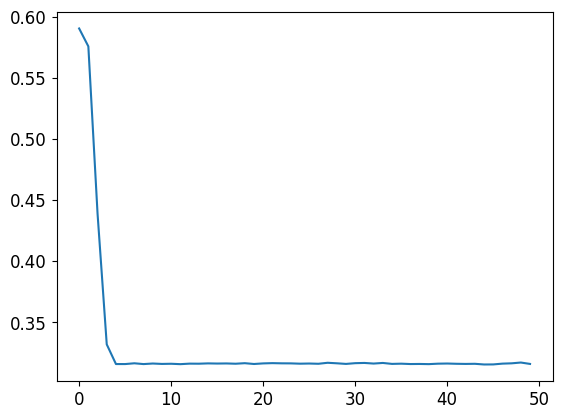

In [10]:
import matplotlib.pyplot as plt
plt.plot(loss_trans_list[0])

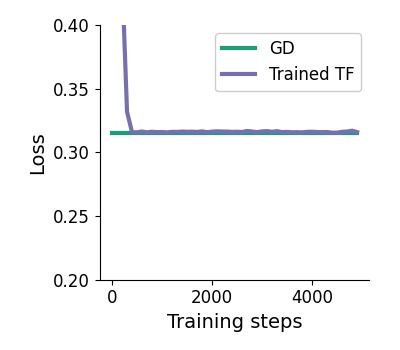

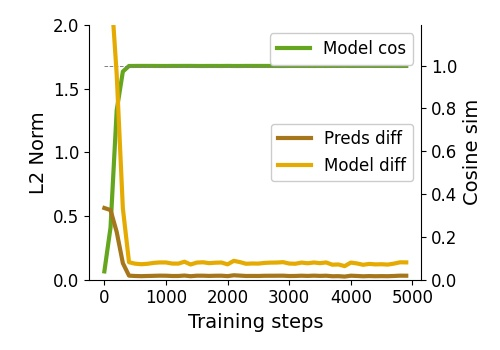

In [11]:
#@title Visualize loss and alignment measures (the printing layout is set to default and might be suboptimal)

cosine_low = 0.0
if config.num_layers == 1:
  display_learning(loss_trans_list, test=[losses_gd_list[0]], y_lim_u=0.4, y_lim_l=0.2,
                  rw=1, title="train.pdf", allow_download=False,
                  single_seeds = True, label_title ="Loss",
                  title2='GD', title1='Trained TF', 
                  title3='GD',  loc_first='upper right',
                  num_iter_os=len(loss_trans_list[0])*100)

  display_learning(cos_sim_list, grad_norm_list, p_norm_list, 
                  title1="Model cos",
                  title2="Model diff", y_lim_u=2,
                  title3="Preds diff", second_axis=True, color_add=0.2,
                  y_lim_u2=1.19, loc_sec='center right', single_seeds = False, 
                  y_lim_l2=cosine_low, color_axis=False, width= 5, y_label2 = 'Cosine sim',
                  rw=1, num_iter_os=len(grad_norm_list[0])*100, title="sim.pdf",
                  allow_download=False)
else:
  display_learning(loss_trans_list, gt=losses_gd_list_trained, 
                   test=[losses_gd_list[0]], y_lim_u=0.3, y_lim_l=0.0,
                   rw=1, title="train.pdf", allow_download=False,
                   title2='GD', title1='Trained TF', 
                   title3='GD$^{++}$',loc_first='upper right', x_label = "Training steps",
                   single_seeds = True, plot_title = None,
                   num_iter_os=len(loss_trans_list[0])*100)
  
  display_learning(cos_sim_list, grad_norm_list, p_norm_list, title1="Model cos",
                  title2="Model diff", y_lim_u=1.8,
                  title3="Preds diff", second_axis=True, color_add=0.2,
                  y_lim_u2=1.09999999, color_axis=False,  width= 4, x_label = "Training steps",
                  plot_title="GD vs trained TF",
                  y_lim_l2=0.5, loc_sec = 'center right', y_label1 = 'L2 Norm', y_label2 = 'Cosine sim',
                  rw=1, num_iter_os=len(loss_trans_list[0])*100, title="sim.pdf",
                  allow_download=False, plot_num=1)
  
  display_learning(cos_sim_list_o, grad_norm_list_o, p_norm_list_o, title1="Model cos",
                  title2="Model diff", y_lim_u=1.8, x_label = "Training steps", plot_title = "GD$^{++}$ vs trained TF" ,
                  title3="Preds diff", second_axis=True, color_add=0.2,
                  y_lim_u2=1.0599999, color_axis=False, width= 4, y_label1 = 'L2 Norm', y_label2 = 'Cosine sim',
                  y_lim_l2=0.5, loc_sec = 'center right',
                  rw=1, num_iter_os=len(loss_trans_list[0])*100, title="sim2.pdf",
                  allow_download=False)

(0.0, 0.6)

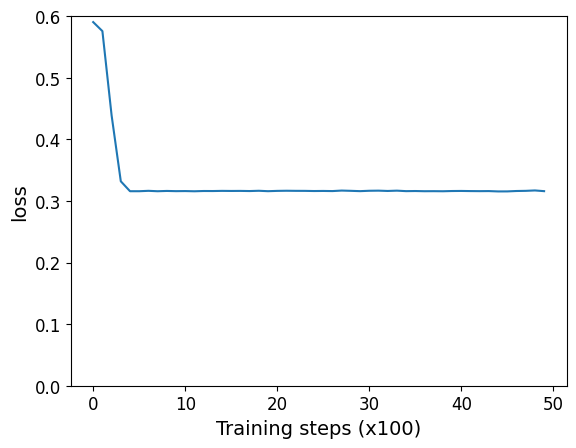

In [12]:
import matplotlib.pyplot as plt 

plt.plot(loss_trans_list[0])
plt.ylabel('loss')
plt.xlabel('Training steps (x100)')
plt.ylim([0,.6])

In [13]:
# save current model for reuse
import pickle
from datetime import datetime

# Assuming `train_state` is the state after training
params = train_state.params

model_id = datetime.now()

# Save parameters to a file
with open(f'model_params_{model_id}.pkl', 'wb') as f:
    pickle.dump(params, f)

with open(f'config_{model_id}.pkl', 'wb') as f:
    pickle.dump(config, f)

# eval on all pairs 

In [14]:
i_size = 14  # 7 classes
n_items = i_size //2
c_size = (i_size//2-1) * 2   # -1 because we leave one adjacent pair out, which the model should be trained on to do linregress
size_distract = 0
input_range = 1.
w_scale = 1.

seq, target, w = create_reg_data_TI_onehot_eval(eval_rng, i_size, c_size, size_distract, input_range, w_scale, (6, 1))

In [15]:
seq

Array([[ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,
         0., -1.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  1.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0., -1.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  1.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1., -1.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0., -1.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
       

In [16]:
preds = predict.apply(train_state.params, eval_rng, jnp.expand_dims(seq,0), False)

In [17]:
preds[0].shape

(13, 15)

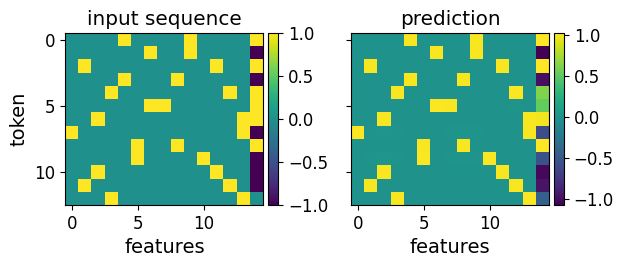

In [18]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
im1 = ax[0].imshow(seq)
im2 = ax[1].imshow(preds[0])

ax[0].set_title('input sequence')
ax[0].set_xlabel('features')
ax[0].set_ylabel('token')
ax[1].set_title('prediction')
ax[1].set_xlabel('features')

divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

# plt.suptitle('Prediction is correct at final point but it doesnt recapture whole sequence (isnt trained to)')
plt.tight_layout()

In [19]:
from itertools import product

TI_data_creator_eval = vmap(create_reg_data_TI_onehot_eval,
                    in_axes=(0, None, None, None, None, None, None),
                    out_axes=0)



In [20]:
# this is with data_creator 
i = 1
j = 4

seq, target, w = create_reg_data_TI_onehot_eval(eval_rng,
                           config.input_size,
                           config.dataset_size,
                           config.size_distract,
                           config.input_range,
                           config.weight_scale,
                           (i, j))

# preds = predict.apply(train_state.params, eval_rng, seq, False)
# preds.shape

In [21]:
pred = predict.apply(train_state.params, eval_rng, jnp.expand_dims(seq,0), False)
pred[0,-1,-1]

Array(-0.0469391, dtype=float32)

In [22]:

# other version 
predict_mat = np.zeros((n_items, n_items))
target_mat = np.zeros((n_items, n_items))

eval_rng, eval_rng2 = jax.random.split(eval_rng, 2)

for i, j in product(range(n_items), range(n_items)):
    seq, target, w = create_reg_data_TI_onehot_eval(eval_rng,
                           config.input_size,
                           config.dataset_size,
                           config.size_distract,
                           config.input_range,
                           config.weight_scale,
                           (i, j))
    preds = predict.apply(train_state.params, eval_rng, jnp.expand_dims(seq,0), False)
    predict_mat[i, j] = preds[0, -1, -1]    
    target_mat[i, j] = target[-1].item()

In [23]:
# n_eval = 100
# predict_mat = np.zeros((n_eval, n_items, n_items))
#  
# for i, j in product(range(n_items), range(n_items)):
#     seq, target, w = TI_data_creator_eval(jax.random.split(eval_rng, num=n_eval),
#                            config.input_size,
#                            config.dataset_size,
#                            config.size_distract,
#                            config.input_range,
#                            config.weight_scale,
#                            (i, j))
#     preds = predict.apply(train_state.params, eval_rng, seq, False)
#     predict_mat[:, i, j] = preds[:, -1, -1]    

In [24]:
predict_mat.ndim

2

([<matplotlib.axis.YTick at 0x7e1cec37ff40>,
 [Text(0, 0, 'A'),
  Text(0, 1, 'B'),
  Text(0, 2, 'C'),
  Text(0, 3, 'D'),
  Text(0, 4, 'E'),
  Text(0, 5, 'F'),
  Text(0, 6, 'G')])

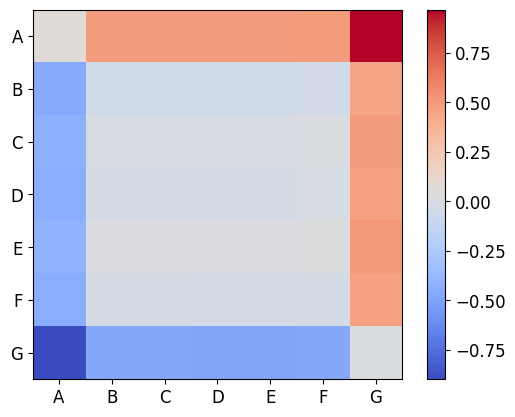

In [25]:
if predict_mat.ndim == 3:
    predict_mat_plot = predict_mat.mean(axis=0)
elif predict_mat.ndim == 2:
    predict_mat_plot = predict_mat
else:
    raise ValueError

import matplotlib.pyplot as plt
symbols = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
plt.imshow(predict_mat_plot, cmap='coolwarm'); plt.colorbar()
plt.xticks(range(7), symbols)
plt.yticks(range(7), symbols)

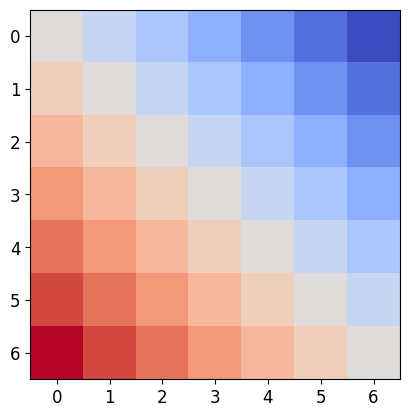

In [26]:
plt.imshow(target_mat, cmap='coolwarm')

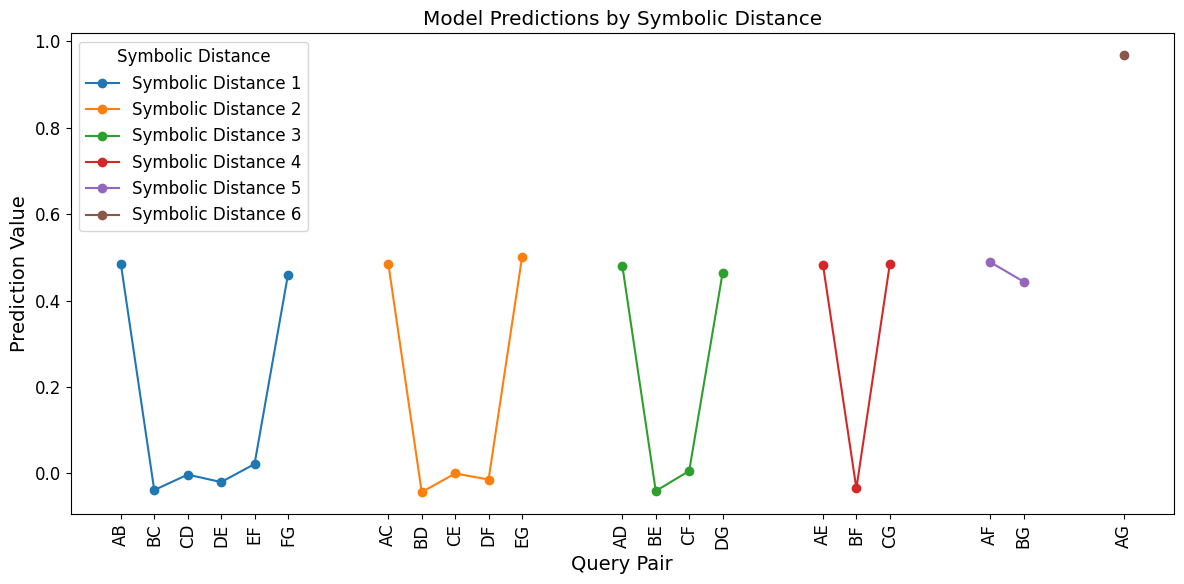

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Example: Generate a random NxN matrix to simulate `predict_mat`
N = 7
# predict_mat = np.random.random((N, N))

# Helper function to generate query labels
def get_query_label(i, j):
    return chr(65 + i) + chr(65 + j)  # Convert indices to characters (A, B, C, ...)

# Create a dictionary to store predictions grouped by symbolic distance
distances = {}

# Loop through the upper triangular matrix excluding diagonal (symbolic distance 0)
for i in range(N):
    for j in range(i + 1, N):  # Upper triangle, excluding the diagonal
        dist = j - i  # Symbolic distance
        if dist > 0:  # Ignore symbolic distance 0
            query_label = get_query_label(i, j)  # Get query label
            prediction = predict_mat_plot[i, j]  # Get prediction value
            
            # Store prediction in the dictionary, grouped by symbolic distance
            if dist not in distances:
                distances[dist] = {'labels': [], 'predictions': []}
            distances[dist]['labels'].append(query_label)
            distances[dist]['predictions'].append(prediction)

# Create a figure
plt.figure(figsize=(12, 6))

# Initialize a list to hold the x positions for the discontinuous axis
x_positions = []
x_ticks = []

# Variable to manage spacing between groups
current_x_pos = 0

# Plot separate lines for each symbolic distance
for dist in sorted(distances.keys()):
    labels = distances[dist]['labels']
    predictions = distances[dist]['predictions']
    
    # Create a range of x positions for the current symbolic distance
    x_pos = np.arange(current_x_pos, current_x_pos + len(labels))
    x_positions.append(x_pos)
    x_ticks.extend(x_pos)  # Collect the positions for x-ticks
    
    # Plot the line for the current symbolic distance
    plt.plot(x_pos, predictions, marker='o', label=f'Symbolic Distance {dist}')
    
    # Update the x position for the next group (to create a gap)
    current_x_pos += len(labels) + 2  # Add a gap of 2 to create space between groups

# Customize the plot
plt.title('Model Predictions by Symbolic Distance')
plt.xlabel('Query Pair')
plt.ylabel('Prediction Value')

# Set the x-ticks to be the center of each group of query pairs
plt.xticks(x_ticks, np.concatenate([distances[dist]['labels'] for dist in sorted(distances.keys())]), rotation=90)

# Add a legend and grid
plt.legend(title='Symbolic Distance')
plt.grid(False)

# Tight layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()
